In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':13.0,'font.serif':'Times New Roman'})

In [2]:
def find_split_point(iteration):
    split_point = []
    for i in range(len(iteration)):
        if iteration[i] == 2000:
            split_point.append(i)
    return split_point

In [3]:
def parse_log_file(path, num_gpu=2):
    train_loss = []
    iteration = []
    epoch_info = []
    with open(path) as file:
        l = file.readline()
        start = 0
        epoch_start=0
        while len(l)>0:
            l = file.readline()
            if l.startswith('Iter'):
                if start%num_gpu == 0:
                    start = l.index('Iter')
                    end = l.index(',')
                    iteration.append(int(l[start+4:end].strip()))
                    train_loss.append(float(l[l.index('Train Loss:')+11:].strip()))
                start = start+1 
            if l.startswith('Epoch'):
                if epoch_start%num_gpu == 0:
                    epoch_info.append(l)
                epoch_start = epoch_start+1
    num_epoch = len(epoch_info)
    split_point = find_split_point(iteration)
    iteration_by_epoch = []
    for i  in range(len(split_point)-1):
        split = split_point[i]
        next_split = split_point[i+1]
        iteration_by_epoch.append(iteration[split:next_split])
    iteration_by_epoch.append(iteration[next_split:])
    total_iteration_per_epoch = []
    for i in range(num_epoch):
        total_iteration_per_epoch.append(iteration_by_epoch[i][-1])
    total_iteration_per_epoch = np.array(total_iteration_per_epoch)
    N = len(iteration)
    loss_train_epoch = []
    loss_test_epoch = []
    f1_test_epoch = []
    acc_test_epoch = []
    time_epoch = []
    for i in range(num_epoch):
        epoch = epoch_info[i]
        train_start = epoch.index('train loss')
        train_end = epoch.index('test loss')
        test_start = train_end
        test_end = epoch.index('test acc')
        acc_start = test_end
        acc_end = epoch.index("test f1")
        f1_start = acc_end
        time_start = epoch.index('epoch time')
        loss_train_epoch.append(float(epoch[train_start+11:train_end-2].strip()))
        loss_test_epoch.append(float(epoch[test_start+10:test_end-2].strip()))
        acc_test_epoch.append(float(epoch[acc_start+10:acc_end-3]))
        f1_test_epoch.append(float(epoch[f1_start+9:time_start-2].strip()))
        time_epoch.append(float(epoch[time_start+12:].strip()))
    average_time_by_epoch = np.array(time_epoch)/total_iteration_per_epoch.reshape(-1,num_epoch)
    epoch_summary = {'time':time_epoch,
                    'test f1':f1_test_epoch,'train loss': loss_train_epoch,
                    'test loss':loss_test_epoch,
                    'time per iter':average_time_by_epoch.flatten()}
    # create per iteration summary 
    end_points = split_point[1:]
    end_points.append(len(iteration))
    duplicate_num = np.array(end_points)-np.array(split_point)

    time = []
    epoch_breakdown=[]
    for i in range(num_epoch):
        time += [epoch_summary['time per iter'][i]] * duplicate_num[i]
        epoch_breakdown += [1/duplicate_num[i]] * duplicate_num[i]
    epoch_breakdown = epoch_breakdown = [np.sum(epoch_breakdown[:i]) for i in range(1,N+1)]
    cut = len(time) # this is to get rid of unfinished epoch
    accumulated_time = [2000*np.sum(time[:i])/60 for i in range(1,N+1)]
    iteration_summary = {'iteration':2000*np.arange(1,cut+1),
                         'train loss':train_loss[:cut],
                         'time per iter':time[:cut],
                         'accumulated time':accumulated_time[:cut],
                         'epoch':epoch_breakdown}
    return iteration_summary, epoch_summary,train_loss[-1],

## A. Different number of GPUs

In [4]:
iteration_summary_1n_1g_b128, epoch_summary_1n_1g_b128, train_loss_1n_1g_b128 = parse_log_file('Log/log_1n_1g_b128.out',1)
iteration_summary_2n_1g_b128, epoch_summary_2n_1g_b128, train_loss_2n_1g_b128 = parse_log_file('Log/log_2n_1g_b128.out',1)
iteration_summary_4n_1g_b128, epoch_summary_4n_1g_b128, train_loss_4n_1g_b128 = parse_log_file('Log/log_4n_1g_b128.out',1)
iteration_summary_2n_4g_b128, epoch_summary_2n_4g_b128, train_loss_2n_4g_b128 = parse_log_file('Log/log_2n_4g_b128.out',4)

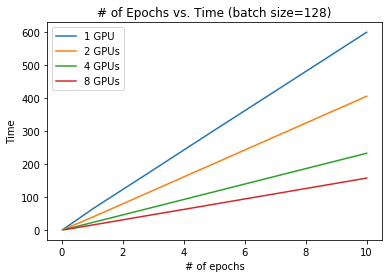

In [5]:
plt.plot(iteration_summary_1n_1g_b128['epoch'], iteration_summary_1n_1g_b128['accumulated time'], label='1 GPU')
plt.plot(iteration_summary_2n_1g_b128['epoch'], iteration_summary_2n_1g_b128['accumulated time'], label='2 GPUs')
plt.plot(iteration_summary_4n_1g_b128['epoch'], iteration_summary_4n_1g_b128['accumulated time'], label='4 GPUs')
plt.plot(iteration_summary_2n_4g_b128['epoch'], iteration_summary_2n_4g_b128['accumulated time'], label='8 GPUs')
plt.xlabel('# of epochs')
plt.ylabel('Time')
plt.title('# of Epochs vs. Time (batch size=128)')
plt.legend()
plt.show()

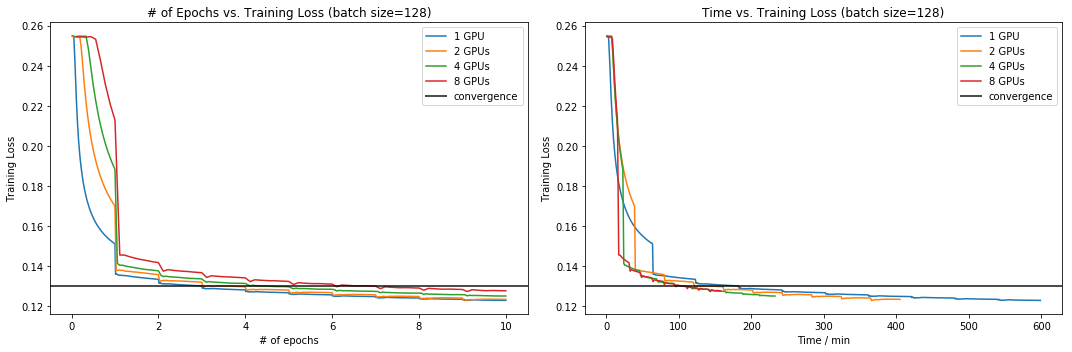

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1, title='# of Epochs vs. Training Loss (batch size=128)')
plt.plot(iteration_summary_1n_1g_b128['epoch'], iteration_summary_1n_1g_b128['train loss'], label='1 GPU')
plt.plot(iteration_summary_2n_1g_b128['epoch'], iteration_summary_2n_1g_b128['train loss'], label='2 GPUs')
plt.plot(iteration_summary_4n_1g_b128['epoch'], iteration_summary_4n_1g_b128['train loss'], label='4 GPUs')
plt.plot(iteration_summary_2n_4g_b128['epoch'], iteration_summary_2n_4g_b128['train loss'], label='8 GPUs')
plt.axhline(0.13, color='k', lw=2, label='convergence',alpha=0.7)
plt.xlabel('# of epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.subplot(1,2,2, title='Time vs. Training Loss (batch size=128)')
plt.plot(iteration_summary_1n_1g_b128['accumulated time'], iteration_summary_1n_1g_b128['train loss'], label='1 GPU')
plt.plot(iteration_summary_2n_1g_b128['accumulated time'], iteration_summary_2n_1g_b128['train loss'], label='2 GPUs')
plt.plot(iteration_summary_4n_1g_b128['accumulated time'], iteration_summary_4n_1g_b128['train loss'], label='4 GPUs')
plt.plot(iteration_summary_2n_4g_b128['accumulated time'], iteration_summary_2n_4g_b128['train loss'], label='8 GPUs')
plt.axhline(0.13, color='k', lw=2, label='convergence',alpha=0.7)
plt.xlabel('Time / min')
plt.ylabel('Training Loss')
plt.legend()
plt.tight_layout()
plt.savefig('A1.png', transparent=True)
plt.show()

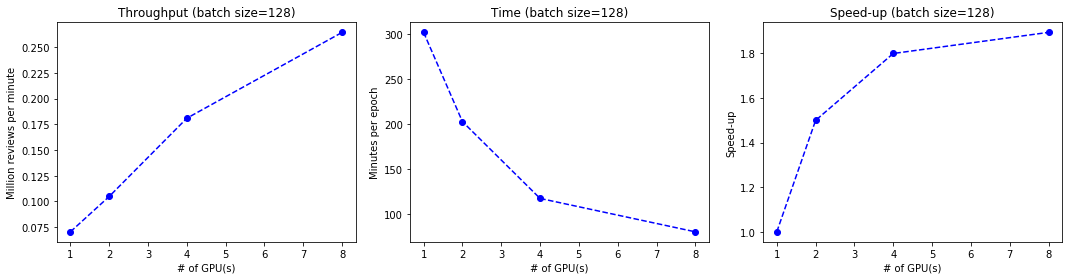

In [7]:
N = 21.28
plt.figure(figsize=(15,4))
plt.subplot(1,3,1, title='Throughput (batch size=128)')
plt.plot([1,2,4,8], [N/np.mean(iteration_summary_1n_1g_b128['accumulated time'][1:]), \
                   N/np.mean(iteration_summary_2n_1g_b128['accumulated time'][1:]),
                   N/np.mean(iteration_summary_4n_1g_b128['accumulated time'][1:]),
                   N/np.mean(iteration_summary_2n_4g_b128['accumulated time'][1:])], 'b--o')
plt.xlabel('# of GPU(s)')
plt.ylabel('Million reviews per minute')
plt.subplot(1,3,2, title='Time (batch size=128)')
plt.plot([1,2,4,8], [np.mean(iteration_summary_1n_1g_b128['accumulated time'][1:]), \
                   np.mean(iteration_summary_2n_1g_b128['accumulated time'][1:]),
                   np.mean(iteration_summary_4n_1g_b128['accumulated time'][1:]),
                   np.mean(iteration_summary_2n_4g_b128['accumulated time'][1:])], 'b--o')
plt.xlabel('# of GPU(s)')
plt.ylabel('Minutes per epoch')
plt.subplot(1,3,3, title='Speed-up (batch size=128)')
speed_up = [180/180, 180/120, 180/100, 180/95]
plt.plot([1,2,4,8], speed_up, 'b--o')
plt.xlabel('# of GPU(s)')
plt.ylabel('Speed-up')
plt.tight_layout()
plt.savefig('A2.png', transparent=True)
plt.show()

## B. The performance of different distributions of GPUs per node for a total of 4 GPUs

In [8]:
iteration_summary_2n_2g_b128, epoch_summary_2n_2g_b128, train_loss_2n_2g_b128 = parse_log_file('Log/log_2n_2g_b128.out',2)
iteration_summary_1n_4g_b128, epoch_summary_1n_4g_b128, train_loss_1n_4g_b128 = parse_log_file('Log/log_1n_4g_b128.out',4)

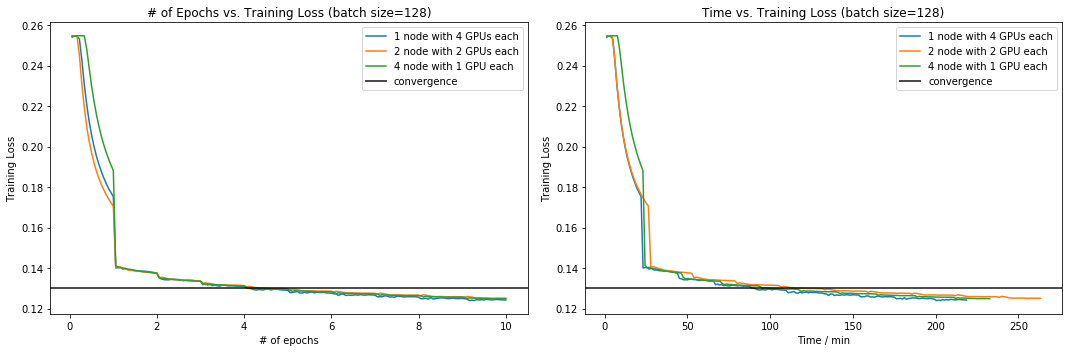

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1, title='# of Epochs vs. Training Loss (batch size=128)')
plt.plot(iteration_summary_1n_4g_b128['epoch'], iteration_summary_1n_4g_b128['train loss'], label='1 node with 4 GPUs each')
plt.plot(iteration_summary_2n_2g_b128['epoch'], iteration_summary_2n_2g_b128['train loss'], label='2 node with 2 GPUs each')
plt.plot(iteration_summary_4n_1g_b128['epoch'], iteration_summary_4n_1g_b128['train loss'], label='4 node with 1 GPU each')
plt.axhline(0.13, color='k', lw=2, label='convergence',alpha=0.7)
plt.xlabel('# of epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.subplot(1,2,2, title='Time vs. Training Loss (batch size=128)')
plt.plot(iteration_summary_1n_4g_b128['accumulated time'], iteration_summary_1n_4g_b128['train loss'], label='1 node with 4 GPUs each')
plt.plot(iteration_summary_2n_2g_b128['accumulated time'], iteration_summary_2n_2g_b128['train loss'], label='2 node with 2 GPU each')
plt.plot(iteration_summary_4n_1g_b128['accumulated time'], iteration_summary_4n_1g_b128['train loss'], label='4 node with 1 GPU each')
plt.axhline(0.13, color='k', lw=2, label='convergence',alpha=0.7)
plt.xlabel('Time / min')
plt.ylabel('Training Loss')
plt.legend()
plt.tight_layout()
plt.savefig('B1.png', transparent=True)
plt.show()

Form:

| # of Node | # of GPUs | Time (min/epoch) | Speed-up |
|-----------|-----------|------------------|----------|
| 1         | 4         | 21.9             | 2.73     |
| 2         | 2         | 26.4             | 2.27     |
| 4         | 1         | 23.3             | 2.57     |

## C. Dynamic load balancer

In [10]:
# total time (secs)
time_1p = 63923/60
time_1g = 35920/60
time_2g = 24316/60
time_4g = 13973/60
time_1g_1p_ndynamic = 39382/60
time_1g_1p_dynamic = 37503/60
time_3g_1p_ndynamic = 24256/60
time_3g_1p_dynamic = 23007/60

# theortical time
time_1g_1p_th = (time_1p - time_1g) / 2 + time_2g
time_3g_1p_th = (time_1p - time_1g) / 4 + time_4g

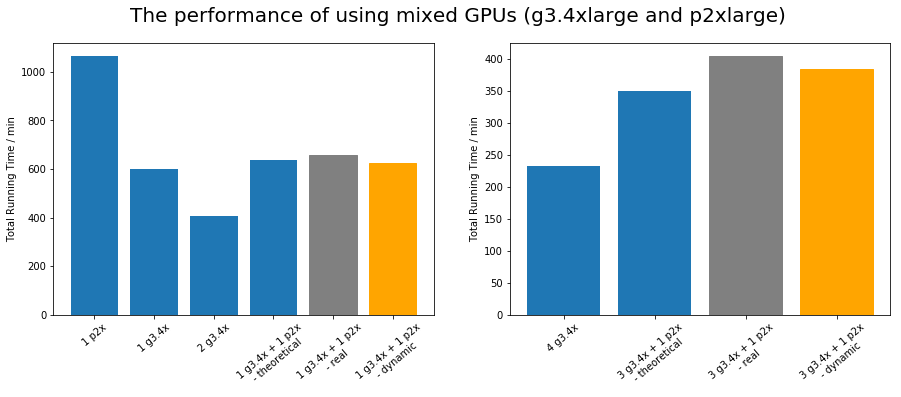

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
names_2n = ['1 p2x', '1 g3.4x', '2 g3.4x', '1 g3.4x + 1 p2x\n- theoretical', \
           '1 g3.4x + 1 p2x\n- real', '1 g3.4x + 1 p2x\n- dynamic']
time_2n = [time_1p, time_1g, time_2g, time_1g_1p_th, time_1g_1p_ndynamic, time_1g_1p_dynamic]
barlist = plt.bar(range(6), time_2n)
barlist[4].set_color('gray')
barlist[5].set_color('orange')
plt.xticks(range(6), names_2n, rotation=40)
plt.ylabel('Total Running Time / min')
plt.subplot(1,2,2)
names_4n = ['4 g3.4x','3 g3.4x + 1 p2x\n- theoretical','3 g3.4x + 1 p2x\n- real', '3 g3.4x + 1 p2x\n- dynamic']
time_4n = [time_4g, time_3g_1p_th, time_3g_1p_ndynamic, time_3g_1p_dynamic]
barlist = plt.bar(range(4), time_4n)
barlist[2].set_color('gray')
barlist[3].set_color('orange')
plt.xticks(range(4), names_4n, rotation=40)
plt.ylabel('Total Running Time / min')
plt.suptitle('The performance of using mixed GPUs (g3.4xlarge and p2xlarge)', fontsize='20')
plt.savefig('C1.png', transparent=True)
plt.show()

## D. Weak Scaling

In [12]:
iteration_summary_1n_1g_b128_25, epoch_summary_1n_1g_b128_25, train_loss_1n_1g_b128_25 = parse_log_file('Log/log_1n_1g_b128_25.out',1)
iteration_summary_2n_1g_b128_50, epoch_summary_2n_1g_b128_50, train_loss_2n_1g_b128_50 = parse_log_file('Log/log_2n_1g_b128_50.out',1)

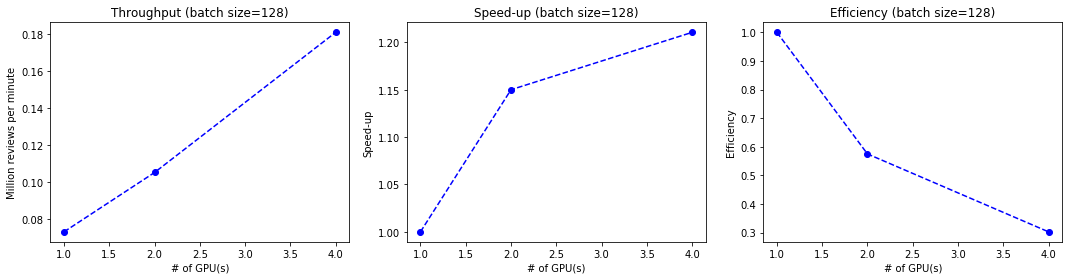

In [27]:
N = 21.28
plt.figure(figsize=(15,4))
plt.subplot(1,3,1, title='Throughput (batch size=128)')
plt.plot([1,2,4], [0.25*N/np.mean(iteration_summary_1n_1g_b128_25['accumulated time'][1:]), \
                   0.5*N/np.mean(iteration_summary_2n_1g_b128_50['accumulated time'][1:]),
                   N/np.mean(iteration_summary_4n_1g_b128['accumulated time'][1:])], 'b--o')
plt.xlabel('# of GPU(s)')
plt.ylabel('Million reviews per minute')
plt.subplot(1,3,2, title='Speed-up (batch size=128)')
speed_up = [115/115, 115/100, 115/95]
plt.plot([1,2,4], speed_up, 'b--o')
plt.xlabel('# of GPU(s)')
plt.ylabel('Speed-up')
plt.subplot(1,3,3, title='Efficiency (batch size=128)')
efficiency = [115/115, 115/100/2, 115/95/4]
plt.plot([1,2,4], efficiency, 'b--o')
plt.xlabel('# of GPU(s)')
plt.ylabel('Efficiency')
plt.tight_layout()
plt.savefig('D1.png', transparent=True)
plt.show()

## E. MapReduce

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':13.0,'font.serif':'Times New Roman'})

num_nodes = np.array([2,4,8])
time_25 = np.array([99,28,14])
time_50 = [10000,51,30]
time_100 = [10000,10000,55]
speed_up = 99/time_25
efficiency = speed_up/num_nodes
throughput = 0.25/time_25

weak_scaling = [99,51,55]

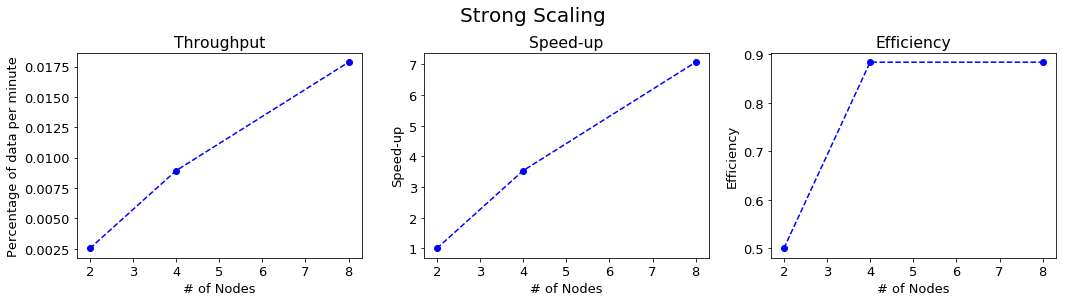

In [11]:
plt.figure(figsize=(15,4))
plt.suptitle('Strong Scaling',y=1.05,fontsize=20)
plt.subplot(1,3,1, title='Throughput')
plt.plot(num_nodes,throughput, 'b--o')
plt.xlabel('# of Nodes')
plt.ylabel('Percentage of data per minute')
plt.subplot(1,3,2, title='Speed-up')
plt.plot(num_nodes, speed_up, 'b--o')
plt.xlabel('# of Nodes')
plt.ylabel('Speed-up')
plt.subplot(1,3,3, title='Efficiency')
plt.plot(num_nodes, efficiency, 'b--o')
plt.xlabel('# of Nodes')
plt.ylabel('Efficiency')
plt.tight_layout()
plt.savefig('MapReduce_strong.png', transparent=True)
plt.show()